In [24]:
#!/usr/bin/env python3
#coding=utf-8
import time
from Arm_Lib import Arm_Device
import numpy as np
import ikpy.chain

import argparse
import os
import platform
import shutil
import time
from pathlib import Path

import pyrealsense2 as rs
import numpy as np
import cv2

import torch
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import (
    check_img_size, non_max_suppression, apply_classifier, scale_coords, 
    xyxy2xywh, plot_one_box, strip_optimizer, set_logging, xywh2xyxy)
from utils.torch_utils import select_device, load_classifier, time_synchronized
from matplotlib import pyplot as plt

SERVO_SPEED = 3.5
LINK_LIST = [0,30,83,83,80,90]
TOMATO_SIZE = (0.033, 0.037)  # (单位：米)

GRABBER = {
    'open':80,
    'open_leaf':50,
    'close':160,
    'close_leaf':180,
}
DROP_POSITION = [-0.05,-0.2,0.15]
LEAF_POSITION = [-0.10,0.02,0.15]

def read_servolines(Arm):
    angle = []
    time.sleep(0.02)
    for i in range(6):
        aa = Arm.Arm_serial_servo_read(i+1)
        if aa:
            angle.append(aa)
        else:
            angle.append(0)
        time.sleep(.002)
    time.sleep(.002)
    return angle
    


def servo_write(Arm,angle,servo_speed,s_time=None):
    calculate_time = calculate_servotime(Arm,angle,servo_speed)
    # s_time = 1500
    if s_time:
        Arm.Arm_serial_servo_write6(angle[0], angle[1], angle[2], angle[3], angle[4], angle[5], s_time)
        time.sleep(s_time/1000)
        return s_time
    else:
        Arm.Arm_serial_servo_write6(angle[0], angle[1], angle[2], angle[3], angle[4], angle[5], calculate_time)
        time.sleep(calculate_time/1000)
        return calculate_time
    

def calculate_servotime(Arm,target,servo_speed=3):
    servotime = np.array(read_servolines(Arm))-np.array(target)
    return int(max(max(np.abs(servotime)) *servo_speed*5,500))

def one_step(model,pipeline,align,names,img_save=True):
    
    frames = pipeline.wait_for_frames()
    aligned_frames = align.process(frames)
    aligned_depth_frame = aligned_frames.get_depth_frame()
    color_frame = aligned_frames.get_color_frame()
    # 将帧转换为numpy数组
    color_image = np.asanyarray(color_frame.get_data())
    color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
    depth_intrinsics = aligned_depth_frame.profile.as_video_stream_profile().intrinsics
    device = select_device('')
    # path, img, im0s, vid_cap = LoadStreams(source, img_size=320)
    
    img = torch.tensor(color_image)
    img = np.transpose(img, (2, 0, 1))
    half = device.type != 'cpu'  # half precision only supported on CUDA
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    
    img = img.to(device)
    t1 = time_synchronized()
    pred = model(img, augment=True)[0]

    # Apply NMS
    pred = non_max_suppression(pred, 0.88, 0.3, classes=None, agnostic=True)
    t2 = time_synchronized()

    # Process detections
    img = np.array(img.squeeze(0).cpu())
    img = np.transpose(img, (1, 2, 0))
    img = img * 255
    img = img.astype(np.uint8)
    for i, det in enumerate(pred):  # detections per image
        # Print time (inference + NMS)
        print('Done. ({:.3f}s)'.format((t2 - t1)))    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if det is not None:
        for *xyxy, conf, cls in reversed(det):
            label = '%s %.2f' % (names[int(cls)], conf)
            print(xyxy)
            plot_one_box(xyxy, img, label=label, line_thickness=3)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.show()
    if img_save:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite("a.png",img)
    return det,aligned_depth_frame,depth_intrinsics



def camera_to_world(P_cam, T_cam, R_cam):
    """
    将相机坐标系下的点转换为世界坐标系。
    
    参数：
        P_cam (numpy.array): 相机坐标系下的点 (3x1)。
        T_cam (numpy.array): 相机在世界坐标系中的位置 (3x1)。
        R_cam (numpy.array): 相机的旋转矩阵 (3x3)。
    
    返回：
        numpy.array: 世界坐标系下的点 (3x1)。
    """
    P_world = R_cam @ P_cam + T_cam
    return P_world

def calculate_frame_coor(det,object_index=2):
    res = []
    for i,(*xyxy, conf, cls) in enumerate(det):
        # 番茄=2,叶子=1,茎=0
        if cls == object_index:
            x = int(xyxy[2]-xyxy[0])
            y = int(xyxy[3]-xyxy[1])
            c_x = int((xyxy[0]+ xyxy[2])/2)
            c_y = int((xyxy[1]+ xyxy[3])/2)
            res.append([i,c_x,c_y,x,y,conf,cls])
    return res

def select_tomato():
    # 根据坐标计算得分并选择番茄,现在是用得分最高的
    # 可以用最靠近一侧的番茄
    pass

def control_arm_coor(Arm,my_chain,target_position,grabber,rotation=90,compensate=2):
    converted_position = np.array(target_position)
    print("target coor:",converted_position)
    joints = my_chain.inverse_kinematics(converted_position,initial_position = np.radians([0,90,120,30,40,90,30]))
    joint_list = joints[1:-2]
    print("servos should be",np.degrees(joint_list))
    joint_deg_list = [int(x)for x in np.degrees(joint_list)]
    joint_deg_list.append(rotation)
    joint_deg_list.append(grabber)
    print("The angles of each joints should be:" , joint_deg_list)
    real_frame = my_chain.forward_kinematics(joints)
    error = np.abs(np.linalg.norm(list(real_frame[:3,3]),ord=2)-np.linalg.norm(converted_position,ord=2))
    print("Error:{:.2f}%".format(error*100))
    print("The position is:\n", real_frame)
    if "{:.2f}%".format(error*0.05) != "0.00%":
        print("out of range")
    else:
        print(joint_deg_list)
        if compensate & all([(x - compensate) < 179 for x in joint_deg_list[1:4]]):
            
            joint_deg_list[1:4] = [(x+compensate) for x in joint_deg_list[1:4]]
            print(f"final joint:{joint_deg_list}")
        return servo_write(Arm,joint_deg_list,SERVO_SPEED),joint_deg_list


def object_axis_angle(xyxy,depth_image, padding=5):
    obj_depth_image = depth_image[(xyxy[1]-padding):(xyxy[3]+padding),(xyxy[0]-padding):(xyxy[2]+padding)]
    hist, bin_edges = np.histogram(obj_depth_image,120,range=(100,600))

    min_val = bin_edges[np.argmax(hist)-3]
    max_val = bin_edges[np.argmax(hist)+3]

    mask = (obj_depth_image > min_val) & (obj_depth_image < max_val)
    # 找到 mask 中为 True 的坐标
    y_coords, x_coords = np.where(mask)
    points = np.column_stack((x_coords, y_coords))  # 转换为点集

    # 计算旋转最小包围矩形
    rect = cv2.minAreaRect(points.astype(np.float32))  # (center, (width, height), angle)

    # 提取矩形参数
    (center_x, center_y), (width, height), angle = rect

    # 短轴的倾斜角计算
    if width < height:
        short_axis_angle = (angle + 90)  # 宽是短轴，直接取 angle
    else:
        short_axis_angle = angle  # 高是短轴，角度加 90°
    print("short_axis_angle:",short_axis_angle)
    return short_axis_angle




def object_position(det,aligned_depth_frame,depth_intrinsics,halfsize=0.007,compen = True,object_index = 2):
    res = calculate_frame_coor(det,object_index)
    
    point_list = []
    depth_image = np.asanyarray(aligned_depth_frame.get_data())
    for obj in res:
        *xyxy, conf, cls = det[obj[0]]
        xyxy = [int(x) for x in xyxy]
        depth_value = aligned_depth_frame.get_distance(obj[1], obj[2]) + halfsize
        point = rs.rs2_deproject_pixel_to_point(depth_intrinsics, [obj[1], obj[2]], depth_value)
        axis_angle = object_axis_angle(xyxy,depth_image, padding=20)
        point = [-point[2],point[0],point[1],int(axis_angle)]
        point_list.append(point)
        print(f"Index:{obj[0]}, Pixel: ({obj[1]}, {obj[2]}) -> Point: {point}")
    
    point_list = np.array(point_list)
    

    
    
    
    try:
        filtered_point_list = point_list[point_list[:, 0] > -0.4]

        sorted_point_list = filtered_point_list[np.argsort(filtered_point_list[:, 0])][::-1]
        # 这里只取最近的
        *P_cam,obj_axis_angle = sorted_point_list[0]
    except:
        return None,None
    # 计算旋转矩阵
    T_cam,R_cam = camera_position(Arm,my_chain)

    # 将相机坐标系的点转换为世界坐标系
    P_world = camera_to_world(P_cam, T_cam, R_cam)
    print("Position of the most confident object to be tomato :", np.array(P_world))
    if compen:
        z = P_world[2]
        z = z + (0.35-z)*0.15
        P_world[2] = z
    return np.array(P_world),obj_axis_angle


def camera_position(Arm,my_chain):
    servos = read_servolines(Arm)
    servos = np.radians([0,servos[0],servos[1],servos[2],servos[3],servos[4],servos[5]])
    transformations = my_chain.forward_kinematics(servos, full_kinematics=True)
    servo4_transform = transformations[4]
    
    print(f"关节 {4} 的变换: {servo4_transform},\n坐标:{servo4_transform[:3,3]}")

    camera_offset_z_rotated = np.array([
    [0,  0, -1, 0.04],
    [1,  0,  0, -0.06],
    [0, 1,  0, -0.03],
    [0, 0, 0, 1]
    ])   
    camera_transform = np.dot(servo4_transform, camera_offset_z_rotated)
    camera_position = camera_transform[:3, 3]
    camera_rotation = camera_transform[:3, :3]
    print("摄像头的位置（相对于世界坐标系）：", camera_position)
    return camera_position,camera_rotation


待解决事项（优先度）：

    1. 只抓能抓到的

        a. 通过番茄距离估计该串番茄大概位置范围

        b. 通过检测到的stem计算主干位置

        c. 通过深度图估计番茄是否被遮挡---最可能实现

            提取深度图

    2. 旋转夹子从番茄短轴接近（准备在论文中添加）

        a. 直接在神经网络中标注直接预测

        b. 通过深度图的梯度计算
        
    3. 论文中使用单目估计作为baseline，确认方法的提升
    

In [16]:

my_chain = ikpy.chain.Chain.from_urdf_file("/home/jetson/code/yolov5/yolov5-3.0/arm_real copy.URDF",active_links_mask=[False,True,True,True,True,True,False])
Arm = Arm_Device()
Arm.Arm_serial_set_torque(0)


In [17]:
Arm.Arm_serial_set_torque(1)
servo_write(Arm,[90,90,90,90,90,0],SERVO_SPEED,1500)
# object_position(det,aligned_depth_frame,depth_intrinsics)
camera_position(Arm,my_chain)

关节 4 的变换: [[    0.99848   -0.017429    0.052336   0.0084648]
 [  -0.052328  0.00090972     0.99863 -0.00043764]
 [  -0.017452    -0.99985 -3.6732e-06     0.27296]
 [          0           0           0           1]],
坐标:[  0.0084648 -0.00043764     0.27296]
摄像头的位置（相对于世界坐标系）： [    0.04788   -0.032544     0.33225]


(array([    0.04788,   -0.032544,     0.33225]),
 array([[  -0.017429,    0.052336,    -0.99848],
        [ 0.00090972,     0.99863,    0.052328],
        [   -0.99985, -3.6732e-06,    0.017452]]))

In [18]:
# 初始化RealSense管道
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

# 启动管道
pipeline.start(config)
align_to = rs.stream.color
align = rs.align(align_to)

In [19]:
control_arm_coor(Arm,my_chain,[-0.05,0.05,0.23],GRABBER['open'])

target coor: [      -0.05        0.05        0.23]
servos should be [         45       171.6      17.984     0.20211]
The angles of each joints should be: [45, 171, 17, 0, 90, 80]
Error:0.00%
The position is:
 [[     0.7071    -0.12018    -0.69682   -0.050012]
 [    0.70711     0.12018     0.69681    0.050012]
 [-3.0489e-06    -0.98545     0.16996     0.23001]
 [          0           0           0           1]]
[45, 171, 17, 0, 90, 80]


(1575, [45, 171, 17, 0, 90, 80])

In [20]:
# target = [135, 96, 29, 22, 90, 150]
# servo_write(Arm,target,SERVO_SPEED)
model = attempt_load('/home/jetson/code/yolov5/yolov5-3.0/0214.pt', map_location=select_device('')).half()  # load FP32 model
# Run inference
img = torch.zeros((1, 3, 640, 640), device=select_device(''))  # init img
_ = model(img.half())
names = ['leaf','stem','tomato',]


Fusing layers... 


target coor: [      -0.05        0.05        0.28]
servos should be [         45      155.83      33.102      10.695]
The angles of each joints should be: [45, 155, 33, 10, 90, 80]
Error:0.00%
The position is:
 [[     0.7071    -0.23755    -0.66601       -0.05]
 [    0.70711     0.23755     0.66601        0.05]
 [-2.4392e-06    -0.94188     0.33595        0.28]
 [          0           0           0           1]]
[45, 155, 33, 10, 90, 80]
Done. (1.615s)
[tensor(410.65625, device='cuda:0', grad_fn=<SelectBackward>), tensor(142.65625, device='cuda:0', grad_fn=<SelectBackward>), tensor(482.84375, device='cuda:0', grad_fn=<SelectBackward>), tensor(208.59375, device='cuda:0', grad_fn=<SelectBackward>)]
[tensor(301.31250, device='cuda:0', grad_fn=<SelectBackward>), tensor(285.12500, device='cuda:0', grad_fn=<SelectBackward>), tensor(367.18750, device='cuda:0', grad_fn=<SelectBackward>), tensor(356.37500, device='cuda:0', grad_fn=<SelectBackward>)]
[tensor(306.28125, device='cuda:0', grad_fn=<

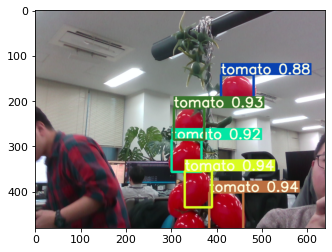

short_axis_angle: 90.0
Index:0, Pixel: (360, 394) -> Point: [-0.23800000548362732, 0.012806105427443981, 0.06016428396105766, 90]
short_axis_angle: 180.0
Index:1, Pixel: (422, 442) -> Point: [-0.23400001227855682, 0.03602144494652748, 0.07728608697652817, 180]
short_axis_angle: 86.3086166381836
Index:2, Pixel: (339, 250) -> Point: [-0.26899999380111694, 0.005350936204195023, 0.005465347785502672, 86]
short_axis_angle: 166.86598205566406
Index:3, Pixel: (334, 320) -> Point: [-0.25300002098083496, 0.0029896777123212814, 0.033731330186128616, 166]
short_axis_angle: 180.0
Index:4, Pixel: (446, 175) -> Point: [-0.2680000066757202, 0.051643069833517075, -0.027004441246390343, 180]
关节 4 的变换: [[    0.22616     0.65681     0.71934    0.062978]
 [   -0.23419    -0.68015     0.69466   -0.065068]
 [    0.94552    -0.32557 -3.6732e-06     0.22157]
 [          0           0           0           1]],
坐标:[   0.062978   -0.065068     0.22157]
摄像头的位置（相对于世界坐标系）： [   0.011036   -0.054466     0.27893]
Pos

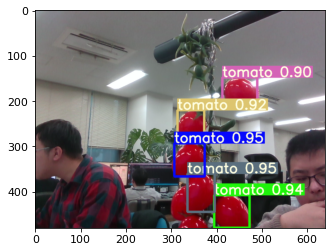

short_axis_angle: 90.0
Index:0, Pixel: (341, 329) -> Point: [-0.25200000405311584, 0.0058267381973564625, 0.037259459495544434, 90]
short_axis_angle: 90.0
Index:1, Pixel: (366, 402) -> Point: [-0.2370000034570694, 0.015048841945827007, 0.06297240406274796, 90]
short_axis_angle: 180.0
Index:2, Pixel: (434, 443) -> Point: [-0.23499999940395355, 0.04072970896959305, 0.07799573987722397, 180]
short_axis_angle: 90.0
Index:3, Pixel: (344, 256) -> Point: [-0.2670000195503235, 0.0074671912007033825, 0.0080109853297472, 90]
short_axis_angle: 36.869895935058594
Index:4, Pixel: (451, 181) -> Point: [-0.26899999380111694, 0.05400795489549637, -0.02449955977499485, 36]
关节 4 的变换: [[    0.24185     0.66446     0.70711    0.062685]
 [   -0.24184    -0.66446     0.70711   -0.062543]
 [    0.93969    -0.34202 -3.6732e-06     0.22314]
 [          0           0           0           1]],
坐标:[   0.062685   -0.062543     0.22314]
摄像头的位置（相对于世界坐标系）： [   0.011278   -0.053562     0.28124]
Position of the most c

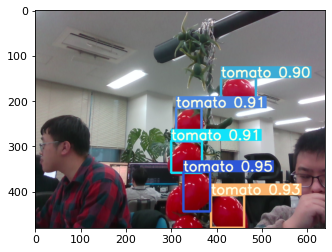

short_axis_angle: 90.0
Index:0, Pixel: (357, 400) -> Point: [-0.2330000102519989, 0.011408178135752678, 0.061157263815402985, 90]
short_axis_angle: 180.0
Index:1, Pixel: (425, 443) -> Point: [-0.23499999940395355, 0.03731396049261093, 0.07799573987722397, 180]
short_axis_angle: 65.77225494384766
Index:2, Pixel: (334, 323) -> Point: [-0.24800001084804535, 0.00293059297837317, 0.03426581621170044, 65]
short_axis_angle: 90.0
Index:3, Pixel: (339, 252) -> Point: [-0.26600000262260437, 0.005291260778903961, 0.006263257935643196, 90]
short_axis_angle: 14.03624439239502
Index:4, Pixel: (448, 180) -> Point: [-0.26600000262260437, 0.05211685970425606, -0.024655761197209358, 14]
关节 4 的变换: [[    0.24185     0.66446     0.70711    0.062685]
 [   -0.24184    -0.66446     0.70711   -0.062543]
 [    0.93969    -0.34202 -3.6732e-06     0.22314]
 [          0           0           0           1]],
坐标:[   0.062685   -0.062543     0.22314]
摄像头的位置（相对于世界坐标系）： [   0.011278   -0.053562     0.28124]
Position 

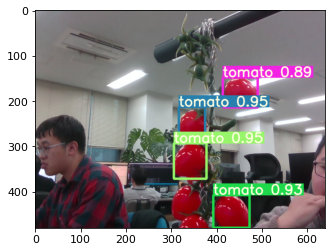

short_axis_angle: 21.250507354736328
Index:0, Pixel: (342, 332) -> Point: [-0.2510000169277191, 0.0062089841812849045, 0.03832725062966347, 21]
short_axis_angle: 90.0
Index:1, Pixel: (346, 253) -> Point: [-0.2680000066757202, 0.008360803127288818, 0.00674300966784358, 90]
short_axis_angle: 180.0
Index:2, Pixel: (433, 443) -> Point: [-0.23800000548362732, 0.04086529091000557, 0.07899143546819687, 180]
short_axis_angle: 141.8427734375
Index:3, Pixel: (452, 181) -> Point: [-0.26899999380111694, 0.0544423907995224, -0.02449955977499485, 141]
关节 4 的变换: [[    0.24185     0.66446     0.70711    0.062685]
 [   -0.24184    -0.66446     0.70711   -0.062543]
 [    0.93969    -0.34202 -3.6732e-06     0.22314]
 [          0           0           0           1]],
坐标:[   0.062685   -0.062543     0.22314]
摄像头的位置（相对于世界坐标系）： [   0.011278   -0.053562     0.28124]
Position of the most confident object to be tomato : [   -0.13707     0.15258     0.28842]
[   -0.13707     0.15258     0.29765]
target coor: [

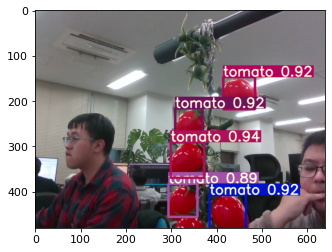

short_axis_angle: 79.69515228271484
Index:0, Pixel: (336, 330) -> Point: [-0.25, 0.0037617317866533995, 0.03736735135316849, 79]
short_axis_angle: 90.0
Index:1, Pixel: (339, 254) -> Point: [-0.26600000262260437, 0.005291260778903961, 0.007122119423002005, 90]
short_axis_angle: 180.0
Index:2, Pixel: (450, 182) -> Point: [-0.2680000066757202, 0.053374361246824265, -0.02397582307457924, 180]
short_axis_angle: 180.0
Index:3, Pixel: (425, 444) -> Point: [-0.2330000102519989, 0.036996398121118546, 0.07770811021327972, 180]
short_axis_angle: 94.69868040084839
Index:4, Pixel: (326, 419) -> Point: [-0.26100000739097595, -0.0002879281237255782, 0.07651244848966599, 94]
关节 4 的变换: [[    0.24185     0.66446     0.70711    0.062685]
 [   -0.24184    -0.66446     0.70711   -0.062543]
 [    0.93969    -0.34202 -3.6732e-06     0.22314]
 [          0           0           0           1]],
坐标:[   0.062685   -0.062543     0.22314]
摄像头的位置（相对于世界坐标系）： [   0.011278   -0.053562     0.28124]
Position of the mos

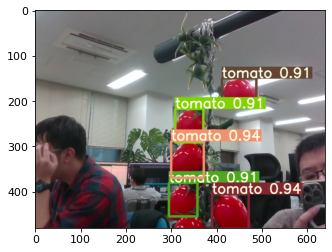

short_axis_angle: 79.69515228271484
Index:0, Pixel: (336, 329) -> Point: [-0.25, 0.0037617317866533995, 0.036963749676942825, 79]
short_axis_angle: 180.0
Index:1, Pixel: (430, 443) -> Point: [-0.23900000751018524, 0.03987903147935867, 0.07932333648204803, 180]
short_axis_angle: 90.0
Index:2, Pixel: (340, 254) -> Point: [-0.2670000195503235, 0.005742360837757587, 0.0071488949470222, 90]
short_axis_angle: 90.0
Index:3, Pixel: (327, 417) -> Point: [-0.26100000739097595, 0.00013358949217945337, 0.07566973567008972, 90]
short_axis_angle: 177.95458984375
Index:4, Pixel: (450, 181) -> Point: [-0.2680000066757202, 0.053374361246824265, -0.024408485740423203, 177]
关节 4 的变换: [[    0.24185     0.66446     0.70711    0.062685]
 [   -0.24184    -0.66446     0.70711   -0.062543]
 [    0.93969    -0.34202 -3.6732e-06     0.22314]
 [          0           0           0           1]],
坐标:[   0.062685   -0.062543     0.22314]
摄像头的位置（相对于世界坐标系）： [   0.011278   -0.053562     0.28124]
Position of the most co

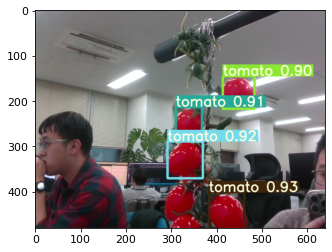

short_axis_angle: 179.26547241210938
Index:0, Pixel: (422, 442) -> Point: [-0.23200000822544098, 0.035713568329811096, 0.0766255185008049, 179]
short_axis_angle: 168.69007110595703
Index:1, Pixel: (331, 330) -> Point: [-0.24700000882148743, 0.0017220537411049008, 0.036918945610523224, 168]
short_axis_angle: 98.74616241455078
Index:2, Pixel: (339, 250) -> Point: [-0.26600000262260437, 0.005291260778903961, 0.0054043959826231, 98]
short_axis_angle: 10.30484676361084
Index:3, Pixel: (449, 181) -> Point: [-0.26600000262260437, 0.05254645273089409, -0.02422633208334446, 10]
关节 4 的变换: [[    0.24185     0.66446     0.70711    0.062685]
 [   -0.24184    -0.66446     0.70711   -0.062543]
 [    0.93969    -0.34202 -3.6732e-06     0.22314]
 [          0           0           0           1]],
坐标:[   0.062685   -0.062543     0.22314]
摄像头的位置（相对于世界坐标系）： [   0.011278   -0.053562     0.28124]
Position of the most confident object to be tomato : [   -0.13616     0.14438     0.28859]
[   -0.13616     0.1

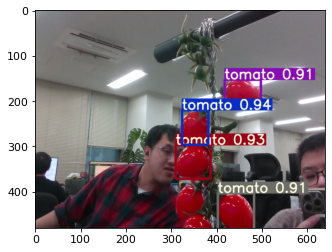

short_axis_angle: 90.0
Index:0, Pixel: (353, 258) -> Point: [-0.27000001072883606, 0.011475566774606705, 0.0089727733284235, 90]
short_axis_angle: 14.03624439239502
Index:1, Pixel: (349, 334) -> Point: [-0.25600001215934753, 0.009226767346262932, 0.039917320013046265, 14]
short_axis_angle: -0.0
Index:2, Pixel: (443, 443) -> Point: [-0.24000000953674316, 0.045084718614816666, 0.0796552300453186, 0]
short_axis_angle: 27.8240966796875
Index:3, Pixel: (458, 183) -> Point: [-0.2709999978542328, 0.05747317522764206, -0.023806706070899963, 27]
关节 4 的变换: [[    0.24185     0.66446     0.70711    0.062685]
 [   -0.24184    -0.66446     0.70711   -0.062543]
 [    0.93969    -0.34202 -3.6732e-06     0.22314]
 [          0           0           0           1]],
坐标:[   0.062685   -0.062543     0.22314]
摄像头的位置（相对于世界坐标系）： [   0.011278   -0.053562     0.28124]
Position of the most confident object to be tomato : [   -0.13558     0.15705     0.28848]
[   -0.13558     0.15705     0.29771]
target coor: [ 

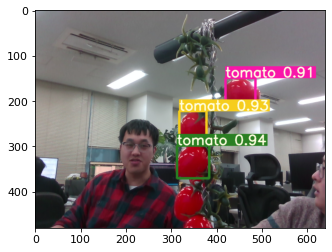

short_axis_angle: 20.556041717529297
Index:0, Pixel: (348, 334) -> Point: [-0.2540000081062317, 0.008744469843804836, 0.03960546478629112, 20]
short_axis_angle: 99.46232223510742
Index:1, Pixel: (348, 256) -> Point: [-0.2709999978542328, 0.009329729713499546, 0.008130999282002449, 99]
short_axis_angle: 180.0
Index:2, Pixel: (453, 183) -> Point: [-0.2709999978542328, 0.05528483912348747, -0.023806706070899963, 180]
关节 4 的变换: [[    0.24185     0.66446     0.70711    0.062685]
 [   -0.24184    -0.66446     0.70711   -0.062543]
 [    0.93969    -0.34202 -3.6732e-06     0.22314]
 [          0           0           0           1]],
坐标:[   0.062685   -0.062543     0.22314]
摄像头的位置（相对于世界坐标系）： [   0.011278   -0.053562     0.28124]
Position of the most confident object to be tomato : [   -0.16089     0.13097      0.3309]
[   -0.16089     0.13097     0.33377]
target coor: [   -0.16089     0.13097     0.33377]
servos should be [     50.849      86.612      52.426      69.689]
The angles of each joi

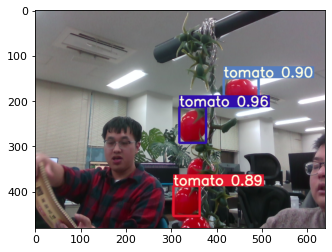

short_axis_angle: 90.0
Index:0, Pixel: (347, 253) -> Point: [-0.26899999380111694, 0.008826437406241894, 0.006768169812858105, 90]
short_axis_angle: 2.045408248901367
Index:1, Pixel: (455, 182) -> Point: [-0.26899999380111694, 0.05574570596218109, -0.024065284058451653, 2]
short_axis_angle: 97.76516485214233
Index:2, Pixel: (334, 420) -> Point: [-0.2600000202655792, 0.003072395920753479, 0.07663904875516891, 97]
关节 4 的变换: [[    0.24185     0.66446     0.70711    0.062685]
 [   -0.24184    -0.66446     0.70711   -0.062543]
 [    0.93969    -0.34202 -3.6732e-06     0.22314]
 [          0           0           0           1]],
坐标:[   0.062685   -0.062543     0.22314]
摄像头的位置（相对于世界坐标系）： [   0.011278   -0.053562     0.28124]
Position of the most confident object to be tomato : [   -0.17784     0.13991     0.29815]
[   -0.17784     0.13991     0.30593]
target coor: [   -0.17784     0.13991     0.30593]
servos should be [     51.805      84.933      47.694      68.176]
The angles of each joint

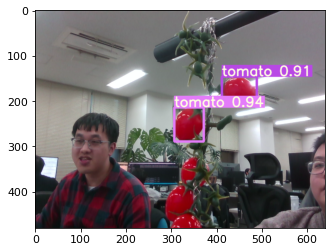

short_axis_angle: 96.80905055999756
Index:0, Pixel: (340, 251) -> Point: [-0.2639999985694885, 0.005677839275449514, 0.005789963994175196, 96]
short_axis_angle: 27.8240966796875
Index:1, Pixel: (451, 179) -> Point: [-0.26500001549720764, 0.053204867988824844, -0.024990888312458992, 27]
关节 4 的变换: [[    0.24185     0.66446     0.70711    0.062685]
 [   -0.24184    -0.66446     0.70711   -0.062543]
 [    0.93969    -0.34202 -3.6732e-06     0.22314]
 [          0           0           0           1]],
坐标:[   0.062685   -0.062543     0.22314]
摄像头的位置（相对于世界坐标系）： [   0.011278   -0.053562     0.28124]
Position of the most confident object to be tomato : [   -0.16153     0.12727      0.3661]
[   -0.16153     0.12727     0.36368]
target coor: [   -0.16153     0.12727     0.36368]
servos should be [      51.76      70.184      67.639      86.045]
The angles of each joints should be: [51, 70, 67, 86, 96.0, 80]
Error:0.00%
The position is:
 [[    0.61896     -0.5443    -0.56624    -0.16153]
 [    0.

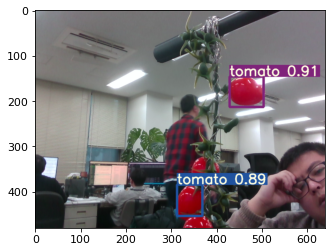

short_axis_angle: 145.7131233215332
Index:0, Pixel: (467, 180) -> Point: [-0.2670000195503235, 0.060505740344524384, -0.024748453870415688, 145]
short_axis_angle: 90.0
Index:1, Pixel: (341, 419) -> Point: [-0.2639999985694885, 0.006104202009737492, 0.07739190012216568, 90]
关节 4 的变换: [[    0.23021     0.66858     0.70711    0.062685]
 [   -0.23021    -0.66858     0.70711   -0.062543]
 [    0.94552    -0.32557 -3.6732e-06     0.22314]
 [          0           0           0           1]],
坐标:[   0.062685   -0.062543     0.22314]
摄像头的位置（相对于世界坐标系）： [   0.010566    -0.05285     0.28049]
Position of the most confident object to be tomato : [   -0.17944     0.14579     0.29326]
[   -0.17944     0.14579     0.30177]
target coor: [   -0.17944     0.14579     0.30177]
servos should be [     50.904      83.212      47.636      69.242]
The angles of each joints should be: [50, 83, 47, 69, 90.0, 80]
Error:0.00%
The position is:
 [[    0.63062    -0.26658    -0.72887    -0.17944]
 [    0.77609     0.2

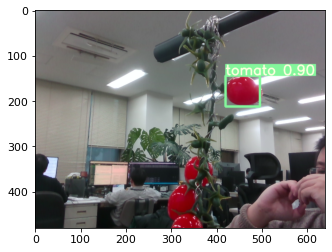

short_axis_angle: 31.429563522338867
Index:0, Pixel: (458, 178) -> Point: [-0.2619999945163727, 0.05556447058916092, -0.025130944326519966, 31]
关节 4 的变换: [[    0.23021     0.66858     0.70711    0.062685]
 [   -0.23021    -0.66858     0.70711   -0.062543]
 [    0.94552    -0.32557 -3.6732e-06     0.22314]
 [          0           0           0           1]],
坐标:[   0.062685   -0.062543     0.22314]
摄像头的位置（相对于世界坐标系）： [   0.010566    -0.05285     0.28049]
Position of the most confident object to be tomato : [   -0.11953     0.15582     0.38955]
[   -0.11953     0.15582     0.38362]
target coor: [   -0.11953     0.15582     0.38362]
servos should be [     37.496      57.779      84.183      92.449]
The angles of each joints should be: [37, 57, 84, 92, 31.0, 80]
Error:0.45%
The position is:
 [[    0.79339    -0.49501    -0.35426    -0.11789]
 [    0.60871     0.64519     0.46174     0.15369]
 [-6.8614e-07    -0.58198      0.8132     0.37998]
 [          0           0           0           1

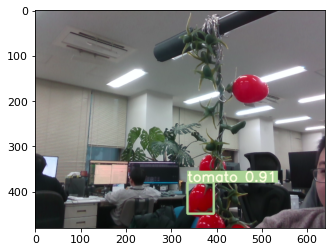

short_axis_angle: 90.0
Index:0, Pixel: (365, 414) -> Point: [-0.2750000059604645, 0.017017610371112823, 0.0783967673778534, 90]
关节 4 的变换: [[    0.23021     0.66858     0.70711    0.062685]
 [   -0.23021    -0.66858     0.70711   -0.062543]
 [    0.94552    -0.32557 -3.6732e-06     0.22314]
 [          0           0           0           1]],
坐标:[   0.062685   -0.062543     0.22314]
摄像头的位置（相对于世界坐标系）： [   0.010566    -0.05285     0.28049]
Position of the most confident object to be tomato : [   -0.17931     0.16109      0.2959]
[   -0.17931     0.16109     0.30401]
target coor: [   -0.17931     0.16109     0.30401]
servos should be [     48.062      76.192      51.582      75.051]
The angles of each joints should be: [48, 76, 51, 75, 90.0, 80]
Error:0.00%
The position is:
 [[    0.66833    -0.28856    -0.68562    -0.17931]
 [    0.74387     0.25926     0.61599     0.16109]
 [-2.2483e-06    -0.92169     0.38792     0.30401]
 [          0           0           0           1]]
[48, 76, 51, 

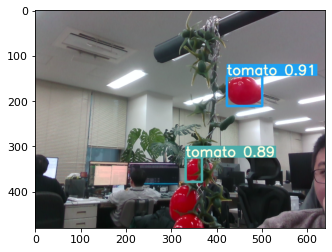

short_axis_angle: 180.0
Index:0, Pixel: (462, 178) -> Point: [-0.2630000114440918, 0.05747554451227188, -0.025226866826415062, 180]
short_axis_angle: 90.0
Index:1, Pixel: (350, 351) -> Point: [-0.004999999888241291, 0.00018828532483894378, 0.000916859193239361, 90]
关节 4 的变换: [[    0.24185     0.66446     0.70711    0.062685]
 [   -0.24184    -0.66446     0.70711   -0.062543]
 [    0.93969    -0.34202 -3.6732e-06     0.22314]
 [          0           0           0           1]],
坐标:[   0.062685   -0.062543     0.22314]
摄像头的位置（相对于世界坐标系）： [   0.011278   -0.053562     0.28124]
Position of the most confident object to be tomato : [  0.0078672   -0.049885     0.28209]
[  0.0078672   -0.049885     0.29228]
target coor: [  0.0078672   -0.049885     0.29228]
servos should be [        180      165.44      26.671      17.298]
The angles of each joints should be: [180, 165, 26, 17, 90.0, 80]
Error:0.01%
The position is:
 [[         -1  6.8074e-06   8.269e-06  0.00010004]
 [-1.0546e-05    -0.49107  

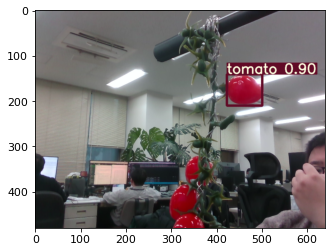

short_axis_angle: 180.0
Index:0, Pixel: (462, 176) -> Point: [-0.2630000114440918, 0.05747554451227188, -0.02607603929936886, 180]
关节 4 的变换: [[    0.23021     0.66858     0.70711    0.062685]
 [   -0.23021    -0.66858     0.70711   -0.062543]
 [    0.94552    -0.32557 -3.6732e-06     0.22314]
 [          0           0           0           1]],
坐标:[   0.062685   -0.062543     0.22314]
摄像头的位置（相对于世界坐标系）： [   0.010566    -0.05285     0.28049]
Position of the most confident object to be tomato : [   -0.11863     0.15763     0.39077]
[   -0.11863     0.15763     0.38465]
target coor: [   -0.11863     0.15763     0.38465]
servos should be [      36.97      54.621          90      89.964]
The angles of each joints should be: [36, 54, 89, 89, 180.0, 80]
Error:0.56%
The position is:
 [[    0.79894    -0.49013    -0.34851    -0.11665]
 [    0.60141     0.65112     0.46299       0.155]
 [-6.7964e-07     -0.5795     0.81497     0.38004]
 [          0           0           0           1]]
[36, 54, 

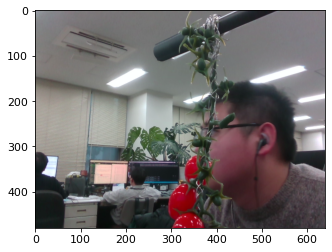

Task on [-0.05, 0.05, 0.28] is finished
target coor: [      -0.05        0.05        0.23]
servos should be [         45       171.6      17.984     0.20211]
The angles of each joints should be: [45, 171, 17, 0, 90, 80]
Error:0.00%
The position is:
 [[     0.7071    -0.12018    -0.69682   -0.050012]
 [    0.70711     0.12018     0.69681    0.050012]
 [-3.0489e-06    -0.98545     0.16996     0.23001]
 [          0           0           0           1]]
[45, 171, 17, 0, 90, 80]
Done. (0.535s)
[tensor(365.53125, device='cuda:0', grad_fn=<SelectBackward>), tensor(288.31250, device='cuda:0', grad_fn=<SelectBackward>), tensor(441.46875, device='cuda:0', grad_fn=<SelectBackward>), tensor(403.68750, device='cuda:0', grad_fn=<SelectBackward>)]


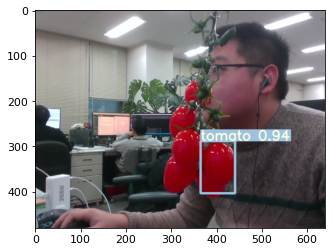

short_axis_angle: 17.744672775268555
Index:0, Pixel: (403, 346) -> Point: [-0.23200000822544098, 0.028594601899385452, 0.04066956415772438, 17]
关节 4 的变换: [[    0.11062      0.6984     0.70711    0.067199]
 [   -0.11061     -0.6984     0.70711   -0.067057]
 [    0.98769    -0.15643 -3.6732e-06     0.20098]
 [          0           0           0           1]],
坐标:[   0.067199   -0.067057     0.20098]
摄像头的位置（相对于世界坐标系）： [  0.0085062    -0.05079     0.24987]
Position of the most confident object to be tomato : [    -0.1378     0.13596     0.24599]
[    -0.1378     0.13596     0.26159]
target coor: [    -0.1378     0.13596     0.26159]
servos should be [     45.386      109.57      30.849      43.762]
The angles of each joints should be: [45, 109, 30, 43, 17.0, 80]
Error:0.00%
The position is:
 [[    0.70232   -0.051883    -0.70996     -0.1378]
 [    0.71186    0.051183     0.70046     0.13596]
 [-3.4055e-06    -0.99734     0.07288     0.26159]
 [          0           0           0           

KeyboardInterrupt: 

In [80]:

task_list = [[-0.05,0.05,0.28],[-0.05,0.05,0.23],[-0.05,0.05,0.17]] # !!!!!!modify here to set the origin position
while task_list:
    target = task_list[0]
    s_time,target_joint_degree_list = control_arm_coor(Arm,my_chain,target,GRABBER['open'])
    time.sleep(1)
    flag = True

    det,aligned_depth_frame,depth_intrinsics = one_step(model,pipeline,align,names)

    while det is not None and flag :
        flag = False
        position_tomato,rotation = object_position(det,aligned_depth_frame,depth_intrinsics)
        if position_tomato is not None:
            print(position_tomato)
            if control_arm_coor(Arm,my_chain,position_tomato,GRABBER['open'],rotation):
                control_arm_coor(Arm,my_chain,position_tomato,GRABBER['close'],rotation)
                control_arm_coor(Arm,my_chain,target,GRABBER['close'])
                control_arm_coor(Arm,my_chain,DROP_POSITION,GRABBER['close'])
                control_arm_coor(Arm,my_chain,DROP_POSITION,GRABBER['open'])
                control_arm_coor(Arm,my_chain,target,GRABBER['open'])
                flag = True
        time.sleep(1)
        det,aligned_depth_frame,depth_intrinsics = one_step(model,pipeline,align,names)



    print(f"Task on {task_list.pop(0)} is finished")



# Below for debug

Done. (8.770s)
[tensor(185.53125, device='cuda:0', grad_fn=<SelectBackward>), tensor(365.53125, device='cuda:0', grad_fn=<SelectBackward>), tensor(279.96875, device='cuda:0', grad_fn=<SelectBackward>), tensor(485.96875, device='cuda:0', grad_fn=<SelectBackward>)]
[tensor(287.37500, device='cuda:0', grad_fn=<SelectBackward>), tensor(3.62500, device='cuda:0', grad_fn=<SelectBackward>), tensor(483.62500, device='cuda:0', grad_fn=<SelectBackward>), tensor(190.37500, device='cuda:0', grad_fn=<SelectBackward>)]
[tensor(313.28125, device='cuda:0', grad_fn=<SelectBackward>), tensor(296.31250, device='cuda:0', grad_fn=<SelectBackward>), tensor(380.21875, device='cuda:0', grad_fn=<SelectBackward>), tensor(470.18750, device='cuda:0', grad_fn=<SelectBackward>)]
[tensor(151.18750, device='cuda:0', grad_fn=<SelectBackward>), tensor(97.25000, device='cuda:0', grad_fn=<SelectBackward>), tensor(274.31250, device='cuda:0', grad_fn=<SelectBackward>), tensor(258.25000, device='cuda:0', grad_fn=<SelectBack

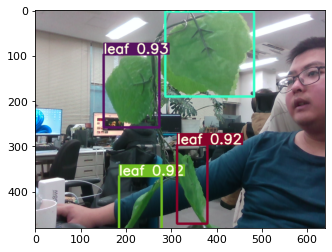

short_axis_angle: 83.9909896850586
Index:0, Pixel: (212, 177) -> Point: [-0.3230000138282776, -0.059824224561452866, -0.03150349482893944, 83]
short_axis_angle: 71.37213897705078
Index:1, Pixel: (346, 383) -> Point: [-0.004999999888241291, 0.0001559851225465536, 0.0011751634301617742, 71]
short_axis_angle: 0.0
Index:2, Pixel: (385, 97) -> Point: [-0.2549999952316284, 0.024016516283154488, -0.05780497193336487, 0]
short_axis_angle: 180.0
Index:3, Pixel: (232, 425) -> Point: [-0.27300000190734863, -0.04174555093050003, 0.08267465233802795, 180]
关节 4 的变换: [[   0.098413     0.70022     0.70711    0.066035]
 [  -0.098408    -0.70023     0.70711   -0.065893]
 [    0.99027    -0.13917 -3.6732e-06     0.20262]
 [          0           0           0           1]],
坐标:[   0.066035   -0.065893     0.20262]
摄像头的位置（相对于世界坐标系）： [  0.0067448   -0.049029     0.25058]
Position of the most confident object to be tomato : [  0.0032383   -0.045302     0.25011]


(array([  0.0032383,   -0.045302,     0.26509]), 71.0)

In [7]:
det,aligned_depth_frame,depth_intrinsics = one_step(model,pipeline,align,names)
object_position(det,aligned_depth_frame,depth_intrinsics,object_index=0)

Done. (0.640s)


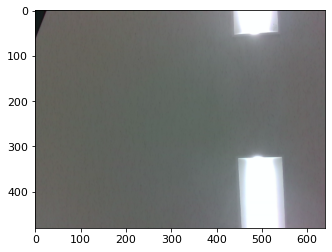

None <pyrealsense2.frame Z16 #22761> [ 640x480  p[326.683 237.415]  f[619.191 619.425]  Inverse Brown Conrady [0 0 0 0 0] ]


In [35]:
# One step

frames = pipeline.wait_for_frames()
aligned_frames = align.process(frames)
aligned_depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()
# 将帧转换为numpy数组
color_image = np.asanyarray(color_frame.get_data())
color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
depth_intrinsics = aligned_depth_frame.profile.as_video_stream_profile().intrinsics
device = torch.device('cuda:0')

img = torch.tensor(color_image)
img = np.transpose(img, (2, 0, 1))
half = device.type != 'cpu'  # half precision only supported on CUDA
img = img.half() if half else img.float()  # uint8 to fp16/32
img /= 255.0  # 0 - 255 to 0.0 - 1.0
if img.ndimension() == 3:
    img = img.unsqueeze(0)

img = img.to(device)
t1 = time_synchronized()
pred = model(img, augment=True)[0]

# Apply NMS
pred = non_max_suppression(pred, 0.81, 0.3, classes=None, agnostic=True)
t2 = time_synchronized()

# Process detections
img = np.array(img.squeeze(0).cpu())
img = np.transpose(img, (1, 2, 0))
img = img * 255
img = img.astype(np.uint8)
for i, det in enumerate(pred):  # detections per image
    # Print time (inference + NMS)
    print('Done. ({:.3f}s)'.format((t2 - t1)))    
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if det is not None:
    for *xyxy, conf, cls in reversed(det):
        label = '%s %.2f' % (names[int(cls)], conf)
        print(xyxy)
        plot_one_box(xyxy, img, label=label, line_thickness=3)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.show()

print(det,aligned_depth_frame,depth_intrinsics)

In [24]:
print(det)
res = calculate_frame_coor(det,object_index=0)
print(res[0])
*xyxy, conf, cls = det[0]
xyxy = [int(x) for x in xyxy]
xyxy

tensor([[371.06250, 155.37500, 621.93750, 425.62500,   0.92937,   0.00000],
        [245.68750, 130.06250, 375.31250, 330.18750,   0.90903,   0.00000]], device='cuda:0', grad_fn=<IndexBackward>)
[0, 496, 290, 250, 270, tensor(0.92937, device='cuda:0', grad_fn=<SelectBackward>), tensor(0., device='cuda:0', grad_fn=<SelectBackward>)]


[371, 155, 621, 425]

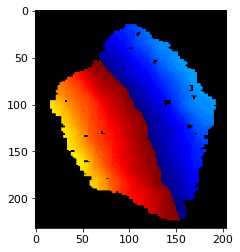

In [ ]:
padding = 10
depth_image = np.asanyarray(aligned_depth_frame.get_data())
obj_depth_image = depth_image[(xyxy[1]-padding):(xyxy[3]+padding),(xyxy[0]-padding):(xyxy[2]+padding)]
hist, bin_edges = np.histogram(obj_depth_image,120,range=(100,600))
min_val = bin_edges[np.argmax(hist)-8]
max_val = bin_edges[np.argmax(hist)+8]
mask = (obj_depth_image > min_val) & (obj_depth_image < max_val)

normalized = np.zeros_like(obj_depth_image, dtype=np.uint8)
normalized[mask] = np.clip(obj_depth_image[mask], min_val, max_val) - min_val


normalized = ((obj_depth_image / (max_val - min_val)) * 255).astype(np.uint8)
depth_colormap = cv2.applyColorMap(normalized, cv2.COLORMAP_JET)
depth_colormap[~mask] = [0, 0, 0]  # 将原始零值位置设为黑色
plt.imshow(depth_colormap)


边缘最小深度点: (149, 48)，深度值: 243
原图中的最小深度点像素坐标: (519, 249)
深度值: 243 mm
3D 坐标: [75.47428131103516, 4.544799327850342, 243.0]


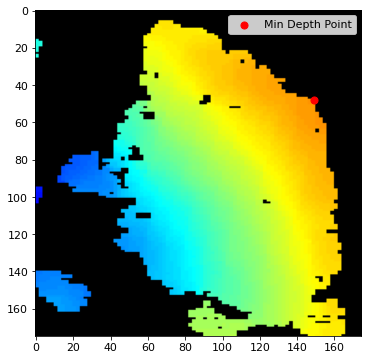

In [66]:
padding = 0
depth_image = np.asanyarray(aligned_depth_frame.get_data())
obj_depth_image = depth_image[(xyxy[1]-padding):(xyxy[3]+padding), (xyxy[0]-padding):(xyxy[2]+padding)]

hist, bin_edges = np.histogram(obj_depth_image, 120, range=(100, 600))
min_val = bin_edges[np.argmax(hist)-10]
max_val = bin_edges[np.argmax(hist)+20]

mask = (obj_depth_image > min_val) & (obj_depth_image < max_val)

# 2. 归一化并创建彩色深度图
normalized = np.zeros_like(obj_depth_image, dtype=np.uint8)
normalized[mask] = np.clip(obj_depth_image[mask], min_val, max_val) - min_val
normalized = ((normalized / (max_val - min_val)) * 255).astype(np.uint8)

depth_colormap = cv2.applyColorMap(normalized, cv2.COLORMAP_JET)
depth_colormap[~mask] = [0, 0, 0]  # 过滤掉背景

# 3. 找到 mask 的边缘
edges = cv2.Canny(mask.astype(np.uint8) * 255, 100, 200)  # Canny 检测边缘
edge_coords = np.column_stack(np.where(edges > 0))  # 获取边缘像素坐标 (y, x)


# 4. 在边缘上找到深度最小的点
min_depth = float('inf')
min_point = None

for (y, x) in edge_coords:
    depth = obj_depth_image[y, x]
    if depth < min_depth and depth != 0:
        min_depth = depth
        min_point = (x, y)  # (x, y) 形式

print(f"边缘最小深度点: {min_point}，深度值: {min_depth}")

if min_point:
    min_point_original = (min_point[0] + xyxy[0], min_point[1] + xyxy[1])
    print(f"原图中的最小深度点像素坐标: {min_point_original}")

    # **2. 获取该像素的深度值**
    depth_value = depth_image[min_point_original[1], min_point_original[0]]
    print(f"深度值: {depth_value} mm")

    # **3. 计算真实世界坐标**
    point_3d = rs.rs2_deproject_pixel_to_point(depth_intrinsics, list(min_point_original), depth_value)
    print(f"3D 坐标: {point_3d}")
else:
    print("未找到有效的最小深度点")


# 5. 可视化结果
plt.figure(figsize=(8, 6))
plt.imshow(depth_colormap)
if min_point:
    plt.scatter(min_point[0], min_point[1], color='red', s=50, label="Min Depth Point")
plt.legend()
plt.show()

5

target coor: [      -0.04        0.07        0.28]
servos should be [     29.772       146.9       41.96      6.7363]
The angles of each joints should be: [29, 146, 41, 6, 90, 80]
Error:0.00%
The position is:
 [[    0.86801    -0.13347    -0.47827       -0.04]
 [    0.49655     0.23331     0.83607        0.07]
 [-2.6859e-06     -0.9632     0.26879        0.28]
 [          0           0           0           1]]
[29, 146, 41, 6, 90, 80]
Done. (0.594s)
[tensor(498.12500, device='cuda:0', grad_fn=<SelectBackward>), tensor(261.75000, device='cuda:0', grad_fn=<SelectBackward>), tensor(650.87500, device='cuda:0', grad_fn=<SelectBackward>), tensor(462.25000, device='cuda:0', grad_fn=<SelectBackward>)]


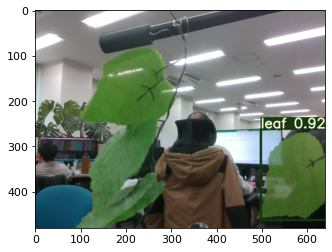

边缘最小深度点: (57, 61)，深度值: 266
原图中的最小深度点像素坐标: (555, 322)
深度值: 0.005 m
3D 坐标: [0.001843670615926385, 0.000682770973071456, 0.004999999888241291]
Index:0, Pixel: (574, 362) -> Point: [0.001843670615926385, 0.000682770973071456, 0.004999999888241291]
short_axis_angle: 90.0
point:[-0.004999999888241291, 0.001843670615926385, 0.000682770973071456, 90]
[[     -0.005   0.0018437  0.00068277          90]]
关节 4 的变换: [[    0.10906     0.47238     0.87462    0.039719]
 [   -0.19674     -0.8522     0.48481   -0.071367]
 [    0.97437    -0.22495 -3.6732e-06     0.23355]
 [          0           0           0           1]],
坐标:[   0.039719   -0.071367     0.23355]
摄像头的位置（相对于世界坐标系）： [    -0.0105   -0.042649     0.28602]
Leaf on task point:[-0.04, 0.07, 0.28] is finished
target coor: [      -0.04        0.07        0.23]
servos should be [     29.771      166.11      18.528      2.1722]
The angles of each joints should be: [29, 166, 18, 2, 90, 80]
Error:0.00%
The position is:
 [[    0.86801   -0.058915    

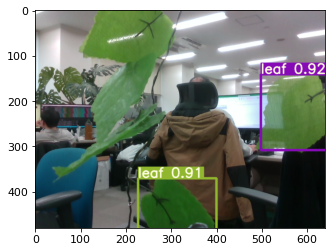

边缘最小深度点: (31, 163)，深度值: 269
原图中的最小深度点像素坐标: (529, 304)
深度值: 0.27900001883506775 m
3D 坐标: [0.09116153419017792, 0.029991095885634422, 0.27900001406669617]
Index:0, Pixel: (576, 225) -> Point: [0.09116153419017792, 0.029991095885634422, 0.27900001406669617]
short_axis_angle: 90.0
point:[-0.27900001406669617, 0.09116153419017792, 0.029991095885634422, 90]
边缘最小深度点: (129, 63)，深度值: 216
原图中的最小深度点像素坐标: (356, 433)
深度值: 0.22200000762939454 m
3D 坐标: [0.010511062107980251, 0.07009711861610413, 0.22200000286102295]
Index:1, Pixel: (314, 427) -> Point: [0.010511062107980251, 0.07009711861610413, 0.22200000286102295]
short_axis_angle: 54.782405853271484
point:[-0.22200000286102295, 0.010511062107980251, 0.07009711861610413, 54]
[[     -0.279    0.091162    0.029991          90]
 [     -0.222    0.010511    0.070097          54]]
关节 4 的变换: [[   0.067476     0.48009     0.87462    0.042718]
 [   -0.12172    -0.86611     0.48481   -0.076778]
 [    0.99027    -0.13917 -3.6732e-06     0.20878]
 [          

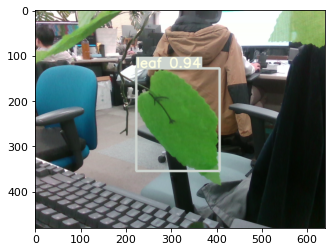

边缘最小深度点: (107, 83)，深度值: 199
原图中的最小深度点像素坐标: (330, 211)
深度值: 0.20500000298023224 m
3D 坐标: [0.0010981577215716243, -0.00874209776520729, 0.20499999821186066]
Index:0, Pixel: (315, 241) -> Point: [0.0010981577215716243, -0.00874209776520729, 0.20499999821186066]
short_axis_angle: 54.360191345214844
point:[-0.20499999821186066, 0.0010981577215716243, -0.00874209776520729, 54]
[[     -0.205   0.0010982  -0.0087421          54]]
关节 4 的变换: [[  -0.075838     0.47884     0.87462    0.033472]
 [    0.13682    -0.86385     0.48481   -0.060098]
 [    0.98769     0.15643 -3.6732e-06     0.20237]
 [          0           0           0           1]],
坐标:[   0.033472   -0.060098     0.20237]
摄像头的位置（相对于世界坐标系）： [   -0.02453   -0.017339      0.2325]
Leaf on task point:[-0.04, 0.07, 0.17] is finished
[[array([  -0.011324,    -0.03736,     0.28648]), 90.0], [array([   -0.11174,     0.16168,     0.21822]), 54.782405853271484], [array([    -0.1224,     0.16148,     0.20906]), 54.360191345214844]]
target coor: 

In [31]:
import json, time
json_file_path = "/home/jetson/code/data.json"
flag_file_path = "/home/jetson/code/flag.log"
with open(json_file_path, "w") as f:
    json.dump({"Status": "Awaiting"},f)
with open(flag_file_path, "r") as f:
    data = f.readlines()
# 循环等待GET请求
flag_leave = False
while True:
    time.sleep(1)
    with open(flag_file_path, "r") as f:
        new_data = f.readlines()
    if len(new_data) != len(data):
        # 抓叶子并往旁边提
        task_list = [[-0.04,0.07,0.28],[-0.04,0.07,0.23],[-0.04,0.07,0.17]] # !!!!!!modify here to set the origin position
        memory_position_leaf = []
        padding = 10
        while task_list:
            target = task_list[0]
            s_time,target_joint_degree_list = control_arm_coor(Arm,my_chain,target,GRABBER['open'])
            time.sleep(1)
            flag = True

            det,aligned_depth_frame,depth_intrinsics = one_step(model,pipeline,align,names)


            res = calculate_frame_coor(det,object_index=0)
            point_list = []
            depth_image = np.asanyarray(aligned_depth_frame.get_data())

            for obj in res:
                *xyxy, conf, cls = det[obj[0]]
                xyxy = [int(x) for x in xyxy]
                
                # 3. 找到 mask 的边缘
                try:
                    obj_depth_image = depth_image[(xyxy[1]-padding):(xyxy[3]+padding), (xyxy[0]-padding):(xyxy[2]+padding)]
                    hist, bin_edges = np.histogram(obj_depth_image, 120, range=(100, 600))
                    min_val = bin_edges[np.argmax(hist)-2]
                    max_val = bin_edges[np.argmax(hist)+4]

                    mask = (obj_depth_image > min_val) & (obj_depth_image < max_val)
                    edges = cv2.Canny(mask.astype(np.uint8) * 255, 100, 200)  # Canny 检测边缘
                    edge_coords = np.column_stack(np.where(edges > 0))  # 获取边缘像素坐标 (y, x)
                    

                # 4. 在边缘上找到深度最小的点
                    min_depth = float('inf')
                    min_point = None

                    for (y, x) in edge_coords:
                        depth = obj_depth_image[y, x]
                        if depth < min_depth and depth != 0:
                            min_depth = depth
                            min_point = (x, y)  # (x, y) 形式
                    print(f"边缘最小深度点: {min_point}，深度值: {min_depth}")
                except:
                    pass
                if min_point:
                    min_point_original = (min_point[0] + xyxy[0], min_point[1] + xyxy[1])
                    print(f"原图中的最小深度点像素坐标: {min_point_original}")

                    # **2. 获取该像素的深度值**
                    depth_value = aligned_depth_frame.get_distance(min_point_original[0], min_point_original[1]) +0.005
                    print(f"深度值: {depth_value} m")

                    # **3. 计算真实世界坐标**
                    point_3d = rs.rs2_deproject_pixel_to_point(depth_intrinsics, list(min_point_original), depth_value)
                    print(f"3D 坐标: {point_3d}")
                else:
                    print("未找到有效的最小深度点")
                        

                
                print(f"Index:{obj[0]}, Pixel: ({obj[1]}, {obj[2]}) -> Point: {point_3d}")
                axis_angle = object_axis_angle(xyxy,depth_image, padding=0)
                point = [-point_3d[2],point_3d[0],point_3d[1],int(axis_angle)]
                print(f"point:{point}")
                point_list.append(point)

            point_list = np.array(point_list)
            filtered_point_list = point_list[point_list[:, 0] > -0.4]
            print(filtered_point_list)
            sorted_point_list = filtered_point_list[np.argsort(filtered_point_list[:, 0])][::-1]
            # 这里只取最近的
            *P_cam,obj_axis_angle = sorted_point_list[0]
            # 计算旋转矩阵
            T_cam,R_cam = camera_position(Arm,my_chain)

            # 将相机坐标系的点转换为世界坐标系
            P_world = camera_to_world(P_cam, T_cam, R_cam)
            # 保存结果并继续寻找
            memory_position_leaf.append([P_world,axis_angle])
            
            print(f"Leaf on task point:{task_list.pop(0)} is finished")


        print(memory_position_leaf)

        if memory_position_leaf is not None:
            control_arm_coor(Arm,my_chain,memory_position_leaf[-1][0],GRABBER['open_leaf'],obj_axis_angle)
            control_arm_coor(Arm,my_chain,memory_position_leaf[-1][0],GRABBER['close_leaf'],obj_axis_angle)
            control_arm_coor(Arm,my_chain,LEAF_POSITION,GRABBER['close_leaf'],obj_axis_angle)
            flag_leave = True
        with open(json_file_path, "w") as f:
            json.dump({"Status": "OK"},f)
        
        break
    if flag_leave:
        break


In [ ]:
memory_position_leaf[0]


array([[     -0.314,   -0.062214,    0.050482,          99],
       [     -0.255,     0.01578,    0.015473,         148]])

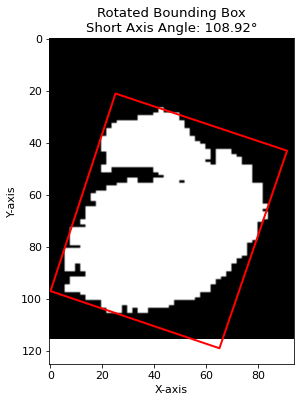

短轴的倾斜角：108.92°


In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 找到 mask 中为 True 的坐标
y_coords, x_coords = np.where(mask)
points = np.column_stack((x_coords, y_coords))  # 转换为点集

# 计算旋转最小包围矩形
rect = cv2.minAreaRect(points.astype(np.float32))  # (center, (width, height), angle)
box = cv2.boxPoints(rect)  # 获取矩形顶点
box = np.int0(box)  # 转换为整数

# 提取矩形参数
(center_x, center_y), (width, height), angle = rect

# 短轴的倾斜角计算
if width < height:
    short_axis_angle = (angle + 90)  # 宽是短轴，直接取 angle
else:
    short_axis_angle = angle  # 高是短轴，角度加 90°

# 绘制原始图像和旋转矩形
plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap="gray", origin="upper")  # 显示原始 mask
plt.plot(
    *np.append(box, [box[0]], axis=0).T,  # 确保闭合
    color="red",
    linewidth=2,
)  # 绘制旋转矩形
plt.title(f"Rotated Bounding Box\nShort Axis Angle: {short_axis_angle:.2f}°")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(False)
plt.show()

# 输出短轴的倾斜角
print(f"短轴的倾斜角：{short_axis_angle:.2f}°")


In [ ]:
import ikpy.chain
from Arm_Lib import Arm_Device
Arm = Arm_Device()
my_chain = ikpy.chain.Chain.from_urdf_file("/home/jetson/code/yolov5/yolov5-3.0/arm_real.URDF")
degree_list = [0,180,130,40,20,90,30]
servo_write(Arm,degree_list[1:],SERVO_SPEED,s_time = 1500)
angle_test = np.radians(degree_list)
transformations = my_chain.forward_kinematics(angle_test, full_kinematics=True)
for i in range(1, len(transformations)):  # 忽略起点（索引0）
    print(f"关节 {i} 的位置: {transformations[i][:3, 3]}")

In [ ]:
transformations = my_chain.forward_kinematics(angle_test, full_kinematics=True)
for i in range(1, len(transformations)):  # 忽略起点（索引0）
    print(f"关节 {i} 的位置: {transformations[i][:3, 3]}")
angle_test = np.radians([0,90,130,30,0,90,30])
print(transformations[-1][:3,3])
joint_list = list(my_chain.inverse_kinematics(transformations[-1][:3,3],initial_position=angle_test))

print(joint_list)
print([0,0,130,51,19,90,30])
print("solve",np.degrees(joint_list))
real_frame = my_chain.forward_kinematics(joint_list, full_kinematics=True)
for i in range(1, len(real_frame)):  # 忽略起点（索引0）
    print(f"关节 {i} 的位置: {real_frame[i][:3, 3]}")

In [ ]:
joint_list = list(my_chain.inverse_kinematics([-0.05,0,0.35],initial_position=angle_test))
print(np.degrees(joint_list))

In [ ]:
target_position = [-0.05,0,0.35]
grabber = 20
converted_position = np.array(target_position)
print("target coor:",converted_position)
joints = my_chain.inverse_kinematics(converted_position,initial_position = np.radians([0,90,130,20,40,90,30]))
joint_list = joints[1:-1]
print("servos should be",np.degrees(joint_list))
joint_deg_list = [int(x)for x in np.degrees(joint_list)]
joint_deg_list.append(grabber)
print("The angles of each joints should be:" , joint_deg_list)
real_frame = my_chain.forward_kinematics(joints)
error = np.abs(np.linalg.norm(list(real_frame[:3,3]),ord=2)-np.linalg.norm(converted_position,ord=2))
print("Error:{:.2f}%".format(error*100))
print("The position is:\n", real_frame)
if "{:.2f}%".format(error*100) != "0.00%":
    print("out of range")
else:
    servo_write(Arm,joint_deg_list,SERVO_SPEED)

model = detect()
names = ['stem','tomato']
det,aligned_depth_frame,depth_intrinsics = one_step(model,pipeline,names)